In [1]:
# Modues to be used
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import json

from re import sub
import ast 

from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Global variables
MASTER_CSV_PATH = '~/Desktop/csgo-csv/'

In [2]:
## READ DATE FROM MASTER ##

# Read the data from all years
# year_vec = ['2012','2013','2014','2015','2016','2017','2018','2019']

year_vec = ['2019']

# Empty data frames
df_player = pd.DataFrame( { } )
df_team   = pd.DataFrame( { } )

df_event = pd.read_csv(MASTER_CSV_PATH+'events.csv')
df_event = df_event.set_index('id')

# Append the data from each year
for year in year_vec:
        
    file_name = MASTER_CSV_PATH + year + '-player-lvl.csv'
    df_player = df_player.append( pd.read_csv( file_name ), ignore_index=True, sort=False )
    
    file_name = MASTER_CSV_PATH + year + '-team-lvl.csv'
    df_team   = df_team.append( pd.read_csv( file_name ), ignore_index=True, sort=False )

In [3]:
# Maping from a map_id to an event
map_to_event_dic = {}

for map_id in df_team.map_id.unique():
    event_id = df_team[ df_team['map_id']==map_id ]['event_id'].unique()[0]
    map_to_event_dic[map_id] = event_id

In [4]:
# Player's relevant stats:
# -> Dictionary that has the players relevant statistics

# Initialize the dictionary entries
player_aux_dic = {}

for player_id in df_player.player_id.unique():
    player_aux_dic[player_id]                 = {}
    player_aux_dic[player_id]['prize_money']  = float( 0.0 )
    player_aux_dic[player_id]['prize_rating'] = float( 0.0 )
    player_aux_dic[player_id]['rating']       = float( 0.0 )

    player_aux_dic[player_id]['map_count']   = 0
    player_aux_dic[player_id]['name']        = df_player[ df_player['player_id']==player_id ]['player_name'].unique()[0]

print('Dictionary initialized')

# Collect the prize money earned by each player:
# -> Here we assume that the prize is divided by 6 (players+coach) evenly
for event_id in df_team['event_id'].unique():

    try:
        # The prize distribution is a string that we convert to a dictionary
        s   = df_event.loc[event_id]['prizeDistribution']
        l   = len(s)
        dic = ast.literal_eval(s[1:l-1])
        
        # Loop through each of the places of the tournament
        for place in dic:
            try:
                prize   = float(sub(r'[^\d.]', '', place['prize']))
                team_id = place['team']['id']

                map_id_vec = df_team[ (df_team['event_id']==event_id) & (df_team['team_id']==team_id) ]['map_id'].unique()

                # Assuming the prize gets divided evenlty between players and coach 
                for player_id in df_player[ (df_player['map_id']==map_id_vec[0]) & (df_player['team_id']==team_id) ].player_id.values:
                    player_aux_dic[player_id]['prize_money'] = player_aux_dic[player_id]['prize_money'] + prize / 6.0

                # for map_id in map_id_vec:
                #     df_tmp = df_player[ (df_player['map_id']==map_id) & (df_player['team_id']==team_id) ]
                    
                #     for player_id in df_tmp.player_id.values:
                #         player_aux_dic[player_id]['rating']    = player_aux_dic[player_id]['rating'] + df_tmp[ df_tmp['player_id']==player_id ]['rating'].values[0]
                #         player_aux_dic[player_id]['map_count'] = player_aux_dic[player_id]['map_count'] + 1

            except:
                continue 

    except:
        continue  
      
print('Prize money collected')

# Now we compute the global rating, including tournaments with no prize money
for map_id in df_team['map_id'].unique():

    # Get a DataFrame with the players that participated in this map
    df_tmp = df_player[ df_player['map_id']==map_id ]

    # Get a sum of all the rating for each player together with a count of the maps played
    for player_id in df_tmp['player_id'].unique():
        rating = df_tmp[ df_tmp['player_id']==player_id ]['rating'].values[0]
        player_aux_dic[player_id]['rating']    = player_aux_dic[player_id]['rating'] + rating
        player_aux_dic[player_id]['map_count'] = player_aux_dic[player_id]['map_count'] + 1

print('Rating for all players collected')

# Now we do some operations on the stats we have
for player_id in df_player.player_id.unique():
    
    # Compute the prize rating
    if player_aux_dic[player_id]['prize_money'] > 0.0:
        player_aux_dic[player_id]['prize_rating'] = np.log( player_aux_dic[player_id]['prize_money'] ) / 12.0
    else:
        player_aux_dic[player_id]['prize_rating'] = 0.0

    # Get the average rating
    if player_aux_dic[player_id]['map_count'] > 0:
        player_aux_dic[player_id]['rating'] = player_aux_dic[player_id]['rating'] / float(player_aux_dic[player_id]['map_count'])
        
print('Normalized ratings')

Dictionary initialized
Prize money collected
Rating for all players collected
Normalized ratings


In [99]:
# Create the feature DataFrame for training/testing

data_dic = {}

for map_id in df_team['map_id'].unique():

    data_dic[map_id] = {}

    df_tmp = df_player[ df_player['map_id']==map_id ]

    # Scores
    t1_id = df_tmp['team_id'].unique()[0]
    t2_id = df_tmp['team_id'].unique()[1]
    
    t1_score = df_team[ (df_team['team_id']==t1_id) & (df_team['map_id']==map_id) ]['team_score'].values[0]
    t2_score = df_team[ (df_team['team_id']==t2_id) & (df_team['map_id']==map_id) ]['team_score'].values[0]

    if t1_score > t2_score:
        data_dic[map_id]['t1_win'] = 1
    else:
        data_dic[map_id]['t1_win'] = 0

    t1_player_count = 0
    t2_player_count = 0

    df_t1 = df_tmp[ df_tmp['team_id']==t1_id ]
    df_t2 = df_tmp[ df_tmp['team_id']==t2_id ]

    count=0
    for ind in df_t1.index:

        player_id = df_t1.loc[ind].player_id

        count = count + 1
        str_aux = 'rating_t1_p'+str(count)        

        data_dic[map_id][str_aux] = {}
        data_dic[map_id][str_aux] = player_aux_dic[player_id]['rating']

        str_aux = 'prize_t1_p'+str(count)        

        data_dic[map_id][str_aux] = {}
        data_dic[map_id][str_aux] = player_aux_dic[player_id]['prize_money']

    count=0
    for ind in df_t2.index:

        player_id = df_t2.loc[ind].player_id

        count = count + 1
        str_aux = 'rating_t2_p'+str(count)        

        data_dic[map_id][str_aux] = {}
        data_dic[map_id][str_aux] = player_aux_dic[player_id]['rating']

        str_aux = 'prize_t2_p'+str(count)        

        data_dic[map_id][str_aux] = {}
        data_dic[map_id][str_aux] = player_aux_dic[player_id]['prize_money']
        


    #data_dic[map_id]['rating_t1_p1']
data = pd.DataFrame.from_dict(data_dic,orient='index')

In [121]:
# Divide data set into training and testing sets
# -> We use 75% of the data for training and 25% for testing
X_train, X_test, y_train, y_test = train_test_split(data.drop('t1_win',axis=1),data['t1_win'], test_size=0.25)

# Make an instance of the model, and increase the maximum number of iterations to avoid convergence problems
logmodel = LogisticRegression(max_iter=500)

X_train

# Training for the model
logmodel.fit(X_train,y_train)

# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = logmodel.predict(X_test)

print(classification_report(y_test,predictions))


precision    recall  f1-score   support

           0       0.65      0.57      0.61      1748
           1       0.68      0.75      0.71      2114

   micro avg       0.67      0.67      0.67      3862
   macro avg       0.67      0.66      0.66      3862
weighted avg       0.67      0.67      0.67      3862

/home/emmanuel/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [104]:
player_aux_dic

6817354133,
  'rating': 1.1804545454545459,
  'map_count': 66,
  'name': 'Laz'},
 11430: {'prize_money': 0.7560826817354133,
  'rating': 1.0725757575757573,
  'map_count': 66,
  'name': 'crow'},
 8875: {'prize_money': 0.8765560993021967,
  'rating': 1.0081182795698926,
  'map_count': 186,
  'name': 'gade'},
 8566: {'prize_money': 0.8888370153723534,
  'rating': 1.0337305699481867,
  'map_count': 193,
  'name': 'LUCAS1'},
 8523: {'prize_money': 0.9865772001436789,
  'rating': 1.0609677419354835,
  'map_count': 217,
  'name': 'tarik'},
 5160: {'prize_money': 0.0,
  'rating': 0.82375,
  'map_count': 8,
  'name': 'natsu'},
 13508: {'prize_money': 0.0,
  'rating': 0.8866666666666666,
  'map_count': 9,
  'name': 'Malikof'},
 10666: {'prize_money': 0.7512613491126011,
  'rating': 1.1343902439024391,
  'map_count': 164,
  'name': 'MAIROLLS'},
 15547: {'prize_money': 0.6852351775678049,
  'rating': 1.0815625000000004,
  'map_count': 128,
  'name': 'scoobyxie'},
 11576: {'prize_money': 0.6692098

In [12]:
#print(player_aux_dic)
#print(prize)

df_money = pd.DataFrame.from_dict(player_aux_dic,orient='index',)
df_money = df_money.sort_values(['prize_money','rating'],ascending=False)

df_money[:60]


,prize_money,rating,map_count,name
7592,1.066097,1.266101,159,device
9032,1.066097,1.199623,159,Magisk
7398,1.066097,1.155220,159,dupreeh
4954,1.066097,1.153648,159,Xyp9x
7412,1.066097,1.101195,159,gla1ve
8797,1.029556,1.106953,233,Stewie2K
8738,1.029376,1.242018,223,EliGE
8520,1.029376,1.213964,222,NAF
10394,1.029376,1.172511,223,Twistzz
7687,1.029376,1.076968,221,nitr0


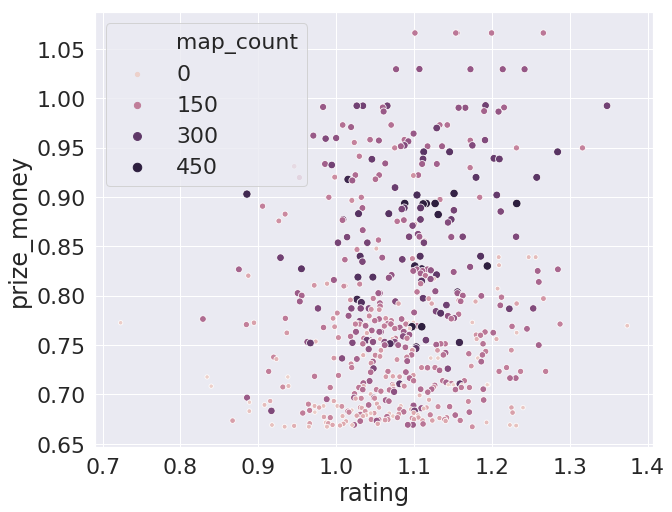

In [14]:
sns.set_style("whitegrid")
sns.set(font_scale=2)

df_tmp = df_money[ df_money['prize_money']>np.log(3000) /12]
plt.figure(figsize=(10,8));

sns.scatterplot(data=df_tmp,x='rating',y='prize_money',size='map_count',hue='map_count');

In [227]:
#X = pd.DataFrame.as_matrix(df_tmp,columns=['rating','prize_money'])
X = pd.DataFrame.as_matrix(df_tmp,columns=['prize_money'])
#X = df_tmp.values(columns=['rating','prize_money'])
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
#df_tmp.sort_values('rating',ascending=False)[:30]

#Z = df_tmp.index.values

df_tmp['label'] = kmeans.labels_

/home/emmanuel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/emmanuel/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [234]:
df_tmp[:60]
df_tmp[(df_tmp['label']==2) | (df_tmp['label']==1)].sort_values('rating',ascending=False)[:60]

,prize_money,rating,map_count,name,label
11893,11.908436,1.355169,178,ZywOo,2
7998,11.396392,1.304773,132,s1mple,2
13776,11.348114,1.288427,178,Jame,2
7592,12.793165,1.267603,146,device,2
3972,11.038301,1.241709,117,huNter,1
8918,11.396392,1.235379,132,electronic,2
14419,10.623256,1.222981,104,roeJ,1
8738,12.352515,1.217576,198,EliGE,2
15631,11.261528,1.211600,175,KSCERATO,2
12126,11.491021,1.210769,91,poizon,2


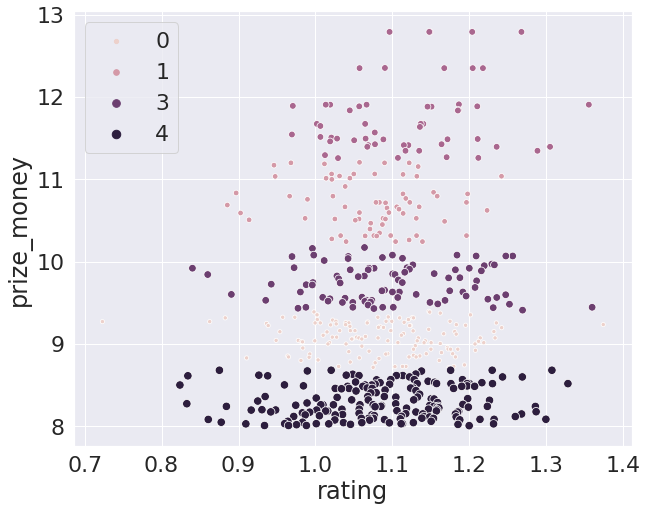

In [229]:
plt.figure(figsize=(10,8));
sns.scatterplot(data=df_tmp,x='rating',y='prize_money',hue=kmeans.labels_,size=kmeans.labels_);
#sns.scatterplot(df_tmp,x='rating',y='prize_money');